# "Introduction to Graph Representation Learning"
## Szkoła letnia AI-Tech 2023
### Autor: Piotr Bielak

![Logotypy sponsorów](../sponsors.png)

In [1]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html, https://data.pyg.org/whl/torch-2.0.0+cu118.html


## 8. Predykcja krawędzi

W wielu przypadkach możemy założyć, że nie posiadamy pełnej informacji o strukturze grafu, tzn. nie obserwujemy w zbiorze wszystkich krawędzi, które w rzeczywistości istnieją w danym grafie. Możemy jednak wyuczyć model, który uzupełni brakujące krawędzie (ang. **link prediction**). 

Zbiór krawędzi grafu dzielimy na zbiór treningowy, walidacyjny oraz testowy. Krawędzie ze zbioru testowego *usuwamy z grafu*, aby były nieobserwowane w trakcie uczenia wektorów reprezentacji (analogicznie dla zbioru walidacyjnego).

Na tym etapie możemy zauważyć pewnien problem – mamy tylko informację o istniejących w grafie krawędziach. Nie wiadomo jak wyuczyć model klasyfikatora? Potrzebowalibyśmy jeszcze informacji o krawędziach, które nie istnieją w grafie, wtedy możemy uznać istniejące krawędzie (przykłady pozytywne) jako klasę $1$, a nieistniejące (przykłady negatywne) jako klasę $0$. 

Dokładnie tak rozwiążemy nasz problem – każdej krawędzi w obecnym zbiorze treningowym i testowym przypisujemy klasę $1$. Następnie dla każdej krawędzi losujemy ze zbioru wszystkich możliwych krawędzi, taką która nie istnieje w danym grafie i przypisujemy jej klasę $0$ (ang. *balanced negative sampling*).

Wybór odpowiednich negatywnych przypadków jest bardziej skomplikowany i istnieje wiele strategii losowania, jednak pozostaniemy przy najprostszym scenariuszu losując krawędź zgodnie z rozkładem jednostajnym (tzn. każdy wybór tak samo prawdopodobny).

In [2]:
import torch

torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

Jako zbioru do zadania predykcji krawędzi użyjemy zbioru **CiteSeer**, który podobnie jak Cora jest zbiorem cytowań między artykułami.

In [4]:
from torch_geometric.datasets import Planetoid


dataset = Planetoid(root="/tmp/CiteSeer/", name="CiteSeer")

data = dataset[0]

data = data.to(device)

data

Processing...
Done!


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

Usuniemy niepotrzebne informacje ze zbioru:

In [5]:
del data.y
del data.train_mask
del data.val_mask
del data.test_mask

data

Data(x=[3327, 3703], edge_index=[2, 9104])

Podzielmy teraz zbiór na podzbiór treningowy, waliacyjny i testowy.

In [6]:
from torch_geometric.transforms import RandomLinkSplit


train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.4,
    is_undirected=True,
    add_negative_train_samples=False,
)(data)

In [7]:
train_data

Data(x=[3327, 3703], edge_index=[2, 4554], edge_label=[2277], edge_label_index=[2, 2277])

In [8]:
val_data

Data(x=[3327, 3703], edge_index=[2, 4554], edge_label=[910], edge_label_index=[2, 910])

In [9]:
test_data

Data(x=[3327, 3703], edge_index=[2, 5464], edge_label=[3640], edge_label_index=[2, 3640])

**Uwaga:** Ustawiamy argument `add_negative_train_samples=False`, aby dla zbioru treningowego nie były losowane przykłady negatywne – będziemy je losować w każdej epoce treningowej.

**Uwaga 2:** Atrybuty wierzchołków `x` oraz krawędzie `edge_index` będziemy używać do obliczenia wektorów reprezentacji wierzchołkow, natomiast krawędzie `edge_label_index` oraz ich etykiety `edge_label` (0/1) będziemy używać do uczenia modelu / walidacji modelu.

Kolejnym zagadnieniem jest jak otrzymać wektor reprezentacji dla krawędzi, skoro założyliśmy, że korzystamy z wektorów dla wierzchołków? Tutaj również mamy wiele możliwości, jednak najpopularniejszym rozwiązaniem jest wykorzystanie jednej z następujących transformacji wektorów reprezentacji wierzchołków $z_{uv} = z_u \circ z_v$, gdzie $\circ: \mathcal{V} \times \mathcal{V} \to \mathbb{R}^{d}$. Metody te zostały zaproponowane w pracy [Node2vec](https://arxiv.org/pdf/1607.00653.pdf) i są aplikowane na każdym elemencie wektora reprezentacji osobno (ang. *element-wise*):

| Nazwa | Wzór  |
|-------|-------|
| Średnia  | $$ z_{uv} = \frac{z_u + z_v}{2}$$ |
| Hadamard | $$ z_{uv} = z_u * z_v$$ |
| L1       | $$ z_{uv} = |z_u - z_v|$$ |
| L2       | $$ z_{uv} = |z_u - z_v|^2$$ |

Innym podejściem może być konkatenacja wektorów, przy czym wtedy zwiększa się wymiarowość wyjściowa wektorów.

In [10]:
from abc import abstractmethod
from torch import nn


class ToEdgeEmb(nn.Module):
    
    def __init__(self, node_dim: int):
        super().__init__()
        self.node_dim = node_dim
    
    @property
    def output_dim(self) -> int:
        raise NotImplementedError()
    
    @abstractmethod
    def forward(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()



class ToEdgeEmbMean(ToEdgeEmb):
    
    @property
    def output_dim(self) -> int:
        return self.node_dim
    
    def forward(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        return (z[edge_index[0]] + z[edge_index[1]]) / 2

Utwórzmy teraz model do uczenia reprezentacji krawędzi:

In [11]:
class LinkPredictionModel(nn.Module):
    
    def __init__(self, gnn: nn.Module, to_edge_emb: ToEdgeEmb):
        super().__init__()
        
        self.gnn = gnn
        self.to_edge_emb = to_edge_emb
        self.clf_head = nn.Linear(to_edge_emb.output_dim, 1)
        
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        return self.gnn(x=x, edge_index=edge_index)
    
    def score_edges(
        self,
        z: torch.Tensor,
        edge_label_index: torch.Tensor,
    ) -> torch.Tensor:
        z_edge = self.to_edge_emb(z, edge_label_index)
        return self.clf_head(z_edge)

Korzystając ze standardowej pętli uczenia i funkcji binarnej entropii krzyżowej możemy wyuczyć powyższy model:

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from torch.nn import functional as F
from torch_geometric.utils import negative_sampling
from tqdm.auto import trange


def train(model: nn.Module, num_epochs: int):
    losses = {"train": []}
    aucs = {"train": [], "val": [], "test": []}
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
        weight_decay=5e-4,
    )
    
    model = model.to(device)
    
    for epoch in trange(num_epochs, desc="Epochs"):
        # Train
        model.train()
        optimizer.zero_grad()
        
        z = model(train_data.x, train_data.edge_index)
        
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, 
            num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), 
            method="sparse",
        )

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat(
            [
                train_data.edge_label,
                train_data.edge_label.new_zeros(neg_edge_index.size(1))
            ], 
            dim=0,
        )

        edge_scores = model.score_edges(z, edge_label_index).view(-1)
        loss = F.binary_cross_entropy_with_logits(
            input=edge_scores,
            target=edge_label,
        )
        
        loss.backward()
        optimizer.step()
        
        # Log
        model.eval()
        
        with torch.no_grad():
            z = model(data.x, data.edge_index)
            
            val_edge_scores = (
                model
                .score_edges(z, val_data.edge_label_index)
                .view(-1)
                .sigmoid()
                .cpu()
            )
            test_edge_scores = (
                model
                .score_edges(z, test_data.edge_label_index)
                .view(-1)
                .sigmoid()
                .cpu()
            )
                
        losses["train"].append(loss.detach().cpu())
        aucs["train"].append(roc_auc_score(
            y_true=edge_label.cpu(),
            y_score=edge_scores.view(-1).sigmoid().cpu().detach(),
        ))
        aucs["val"].append(roc_auc_score(
            y_true=val_data.edge_label.cpu(),
            y_score=val_edge_scores,
        ))
        aucs["test"].append(roc_auc_score(
            y_true=test_data.edge_label.cpu(),
            y_score=test_edge_scores,
        ))
        
    # Visualize metrics
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
    axs = axs.ravel()
    axs[0].plot(range(num_epochs), losses["train"], label="Train")
    axs[0].set(title="Loss")
    axs[0].legend()
    
    axs[1].plot(range(num_epochs), aucs["train"], label="Train")
    axs[1].plot(range(num_epochs), aucs["val"], label="Val")
    axs[1].plot(range(num_epochs), aucs["test"], label="Test")
    best_val_auc = max(aucs["val"])
    best_idx = aucs["val"].index(best_val_auc)
    best_test_auc = aucs["test"][best_idx]
    
    axs[1].set(title=f"AUC (best val: {best_val_auc:.4f}, test: {best_test_auc:.4f})")
    axs[1].legend()


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

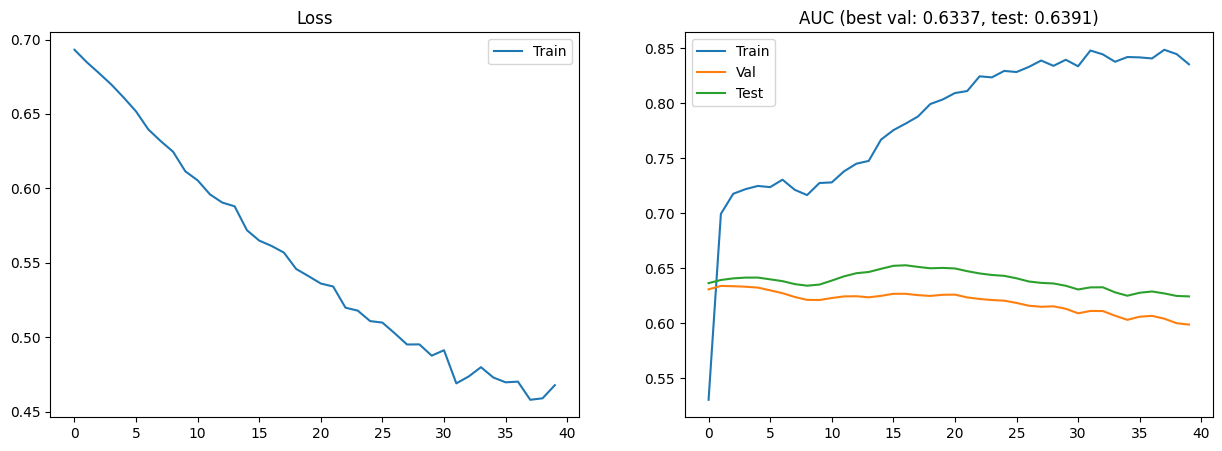

In [13]:
from torch_geometric.nn import GCN


train(
    model=LinkPredictionModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        to_edge_emb=ToEdgeEmbMean(128),
    ),
    num_epochs=40,
)

## Zadanie (10 min)

## Z.3. Implementacja innych operatorów osadzeń krawędziowych

Zaimplementuj pozostałe operatory do uzyskiwania reprezentacji krawędzi (z powższej tabelki oraz operator konkatenacji). Porównaj jakość działania przy zastosowaniu sieci GCN.

In [14]:
class ToEdgeEmbHadamard(ToEdgeEmb):
    
    @property
    def output_dim(self) -> int:
        return self.node_dim
    
    def forward(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        return z[edge_index[0]] * z[edge_index[1]]
    
    
class ToEdgeEmbL1(ToEdgeEmb):
    
    @property
    def output_dim(self) -> int:
        return self.node_dim
    
    def forward(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        return (z[edge_index[0]] - z[edge_index[1]]).abs()
    
    
class ToEdgeEmbL2(ToEdgeEmb):
    
    @property
    def output_dim(self) -> int:
        return self.node_dim
    
    def forward(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        return (z[edge_index[0]] - z[edge_index[1]]).pow(2)
    
    
class ToEdgeEmbConcat(ToEdgeEmb):
    
    @property
    def output_dim(self) -> int:
        return self.node_dim * 2
    
    def forward(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        return torch.cat([z[edge_index[0]], z[edge_index[1]]], dim=-1)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

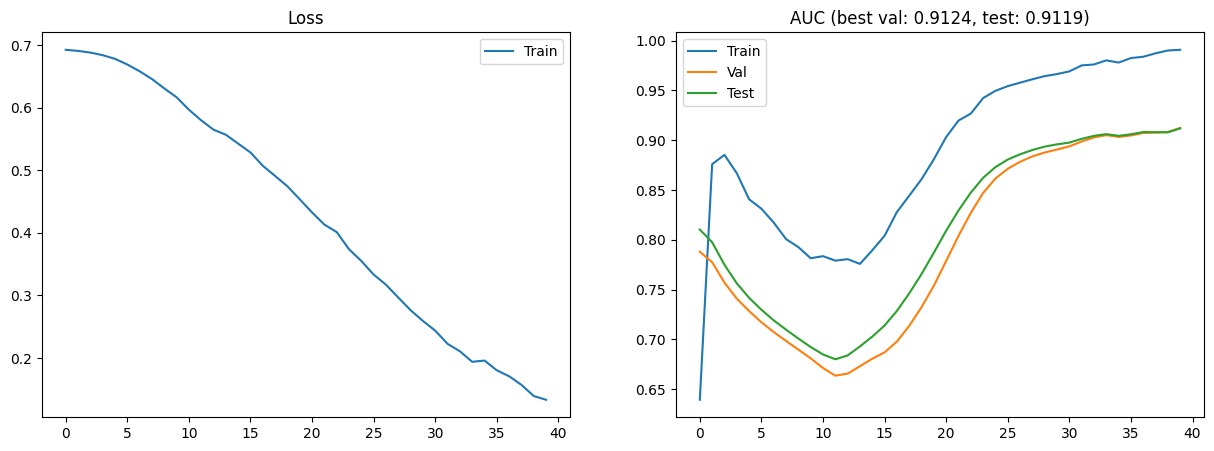

In [15]:
train(
    model=LinkPredictionModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        to_edge_emb=ToEdgeEmbHadamard(128),
    ),
    num_epochs=40,
)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

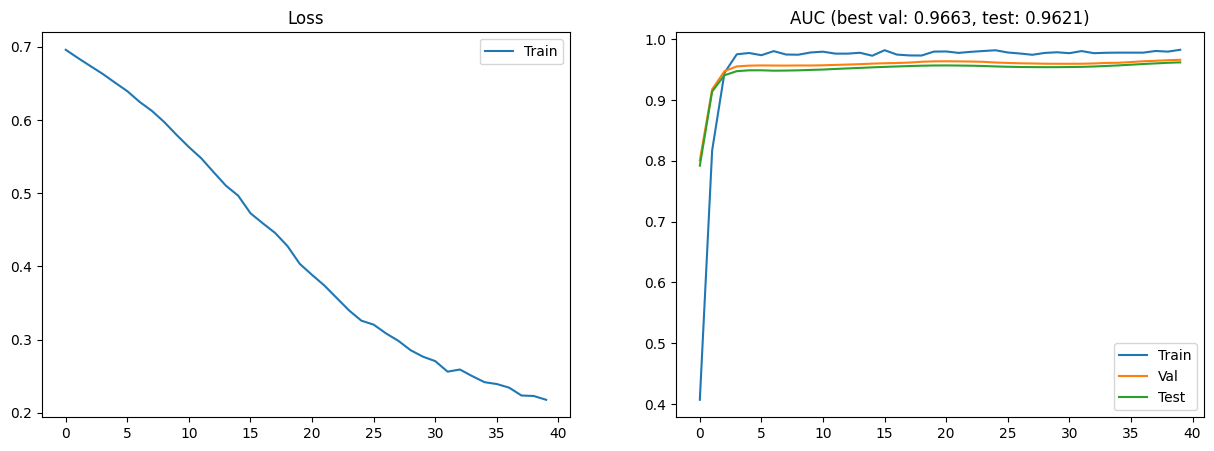

In [16]:
train(
    model=LinkPredictionModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        to_edge_emb=ToEdgeEmbL1(128),
    ),
    num_epochs=40,
)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

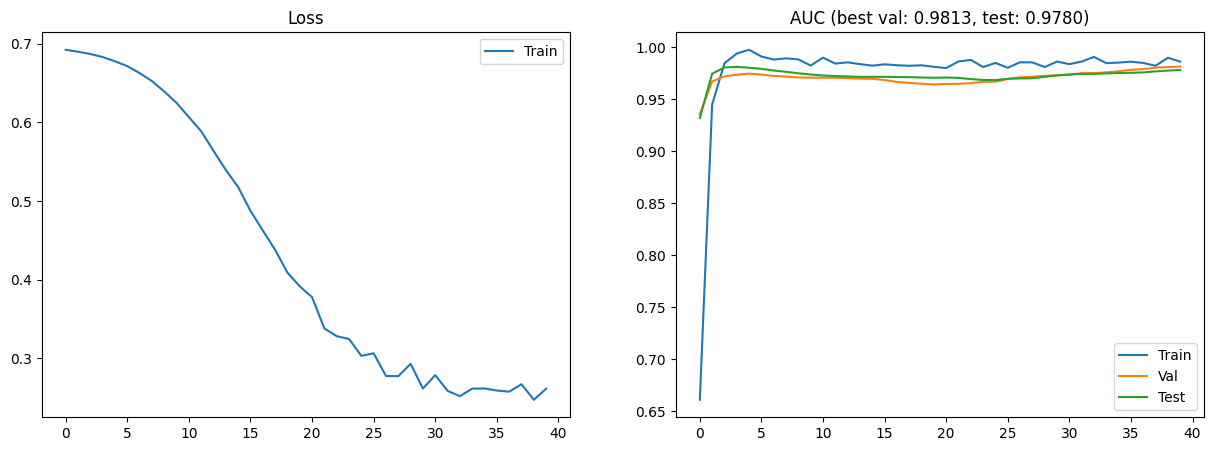

In [17]:
train(
    model=LinkPredictionModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        to_edge_emb=ToEdgeEmbL2(128),
    ),
    num_epochs=40,
)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

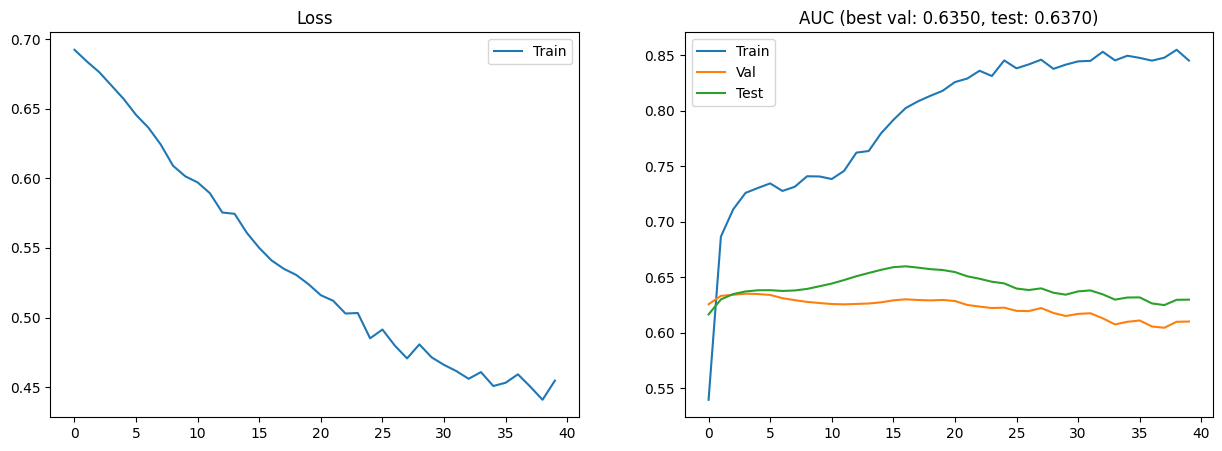

In [18]:
train(
    model=LinkPredictionModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        to_edge_emb=ToEdgeEmbConcat(128),
    ),
    num_epochs=40,
)